# "Tutorial data loader - Pytorch"
> "Writing Custom Datasets, DataLoaders and Transforms"

- toc: true
- branch: master
- badges: true
- comments: false
- numbersections: true
- categories: [pytorch, tutoriais]
- image: images/pytorch.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

# Writing Custom Datasets, DataLoaders and Transforms

[Pytorch - data_loading_tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [1]:
#hide

# %conda install scikit-image

## Imports

In [2]:
#collapse

from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## Download das imagens
- definição do `landmarks_frame`

In [3]:
#collapse
#collapse_output

import requests, zipfile
from pathlib import Path
import os

def download_and_unzip(url):
    print('Iniciando download ...',end='')
#     print('url:',url)
    r = requests.get(url)
    
    # Retrieve HTTP meta-data
    if r.status_code == 200:
        print('OK!')
    elif r.status_code == 404:
        raise ValueError(f'url não encontrada: {url}')
        
    # print(r.headers['content-type'])
    # print(r.encoding)
    
    fname = url.split('/')[-1]  
    folder_path = f'data/'
    file_path = folder_path + fname
    if not os.path.exists(folder_path):
        Path(folder_path).mkdir(parents=True, exist_ok=True)
    
    with open(file_path, 'wb') as f:
        f.write(r.content)
        print(f"Dados salvos em '{file_path}'")

#     extractFromZip(file_path)
# def extractFromZip(file_path):
    subfolder = file_path.split('/')[-1].rstrip('.zip')
    directory_to_extract_to = 'data'
    print(f"Extraindo arquivos para o diretorio '{directory_to_extract_to}' ... ", end='')
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)
        print('OK!')
        
        
def get_face_landmarks(update=True):
    

    fname = f'data/faces/face_landmarks.csv'
    if os.path.isfile(fname) and not update:
        print(f'\nReading data from local file <{fname}>. If you prefer to download last version, set "update=True".\n')
        df = pd.read_csv(fname)
    else:
        url = 'https://download.pytorch.org/tutorial/faces.zip'
        print(f'\nBaixando dados de {url} ')
        download_and_unzip(url)
#         print('OK!\n')
        df = pd.read_csv(fname)       
    
    return df

landmarks_frame = get_face_landmarks()

print('Dimensões: ',landmarks_frame.shape)
n_points = (landmarks_frame.shape[1] - 1 )/2
n_figs = landmarks_frame.shape[0]
print('{} figuras | 1 nome + {:.0f} pontos (x,y)'.format(n_figs,n_points))
landmarks_frame


Baixando dados de https://download.pytorch.org/tutorial/faces.zip 
Iniciando download ...OK!
Dados salvos em 'data/faces.zip'
Extraindo arquivos para o diretorio 'data' ... OK!
Dimensões:  (69, 137)
69 figuras | 1 nome + 68 pontos (x,y)


,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,matt-mathes.jpg,85,152,83,173,83,195,85,217,91,...,160,224,190,225,162,236,151,237,141,235
65,person-7.jpg,32,65,33,76,34,86,34,97,37,...,79,98,91,99,79,99,74,99,69,99
66,person.jpg,78,83,79,93,80,103,81,112,85,...,119,115,132,114,120,121,114,122,109,121
67,person_TjahjonoDGondhowiardjo.jpg,41,92,41,103,43,114,44,125,48,...,85,130,94,130,85,128,81,128,77,128


## Determinação do `landmarks` (np.array, 2D)

In [4]:
#collapse
#collapse_output

n = 65

if n  >= landmarks_frame.shape[0]:
    print('Escolha um valor de n < {}'.format(landmarks_frame.shape[0]))
else:
    img_name = landmarks_frame.iloc[n, 0]
    landmarks = landmarks_frame.iloc[n, 1:]
#     print('Landmarks type: {}'.format(type(landmarks)))
    landmarks = np.asarray(landmarks)
    landmarks = landmarks.astype('float').reshape(-1, 2)

    print('Image name: {}'.format(img_name))
    print('Landmarks type: {}'.format(type(landmarks)))
    print('Landmarks shape: {}'.format(landmarks.shape))
    print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks type: <class 'numpy.ndarray'>
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


### Plotar figura + landmarks

Image name: person-7.jpg


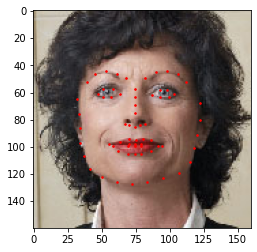

In [5]:
#collapse
#collapse_output

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
print('Image name: {}'.format(img_name))
img_path = 'data/faces/'
show_landmarks(io.imread(os.path.join(img_path, img_name)),
               landmarks)
plt.show()

## Dataset class

A nossa classe deve ser uma classe derivada da classe torch.utils.data.Dataset e sobescrever os seguintes métodos (vou manter no inglês):

    __len__ so that len(dataset) returns the size of the dataset.
    __getitem__ to support the indexing such that dataset[i] can be used to get iiith sample.


In [6]:
#collapse
#collapse_output

class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

- **Dúvida:** o método __getitem__ pode receber um parâmetro do tipo `tensor`? Pq ? Pq transformar em lista?

### Criação de instância da classe para nossas imagens
- loop passando por cada imagem

0 (324, 215, 3) (68, 2)


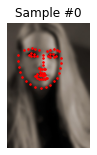

1 (500, 333, 3) (68, 2)


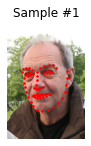

2 (250, 258, 3) (68, 2)


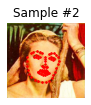

3 (434, 290, 3) (68, 2)


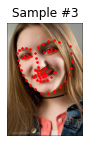

In [7]:
#collapse
#collapse_output

face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

## Transforms

In [8]:
#collapse

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## Compose transforms

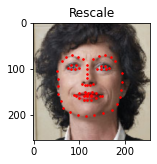

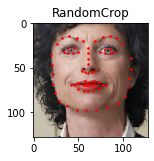

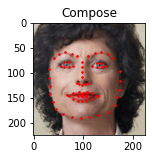

In [9]:
#collapse
#collapse_output

scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## Iterating through the dataset

In [10]:
#collapse
#collapse_output

transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


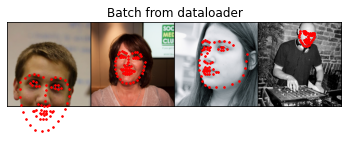

In [11]:
#collapse
#collapse_output

dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Afterword: torchvision
> **Falta entender o que fazer com isso!!!**

In [12]:
#collapse
#collapse_output

url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
download_and_unzip(url)

Iniciando download ...OK!
Dados salvos em 'data/hymenoptera_data.zip'
Extraindo arquivos para o diretorio 'data' ... OK!


In [13]:
#collapse
#collapse_output

import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='data/hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)
len(hymenoptera_dataset)

244